# Traffic Sign Recognition

The Dataset: 

# Initialization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools
import datetime

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
from keras.utils.data_utils import Sequence as KerasSequence

# metrics
import tensorflow_addons as tfa 

# cv2
import cv2

#PIL
from PIL import Image

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# MLOps
import wandb
from wandb.keras import WandbCallback

#XAI
import shap
import keras.backend as K


No supported GPU was found.


In [2]:
print (tf.__version__)

2.7.0


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# General Parameters

In [4]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [5]:
# location of the data
base_dir = ./dataset/GTSRB
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [6]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color='blue', label='Training acc')
        plt.plot(epochs, val_acc, color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

# plot a test image

def get_input_img(sign_class, img_height, img_width, index = 0, dataset='Test'):
    def reshape_img(img):
        img = cv2.resize(img, (img_height,img_width))
        return np.expand_dims(img, axis=0)

    if dataset == 'Train':
        file_path = base_dir + '/Train/' + str(sign_class) + '/'
        file_name = os.listdir(file_path)[index]
        img = cv2.imread(file_path + file_name)
    
    if dataset == 'Test':
        meta = pd.read_csv('./dataset/GTSRB/Test.csv')
        file = meta[meta['ClassId'] == sign_class]['Path'].values[index]
        img = cv2.imread(base_dir + '/' + file)        

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    return reshape_img(img)
        

def plot_feature_maps(model, img):
    successive_outputs = [layer.output for layer in model.layers[1:]]
    inputs = model.inputs
    outputs = successive_outputs
    filters = Model(inputs=inputs, outputs=outputs)
    feature_maps = filters.predict(img)
    layer_names = [layer.name for layer in model.layers]
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(feature_map.shape)
        if len(feature_map.shape) == 4:
            # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x

            #Display the grid
            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' )

# plot kernel weights

def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_filters (model):
    for layer in model.layers:
        if 'conv' in layer.name:
            weights, bias= layer.get_weights()
            #print(layer.name, filters.shape)
            
            #normalize filter values between  0 and 1 for visualization
            f_min, f_max = weights.min(), weights.max()
            filters = (weights - f_min) / (f_max - f_min)  
            print(filters.shape[3])
            filter_cnt=1
            
            #plotting all the filters
            for i in range(filters.shape[3]):
                #get the filters
                filt=filters[:,:,:, i]
                #plotting each of the channel, color image RGB channels
                for j in range(filters.shape[0]):
                    ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                    ax.set_xticks([])
                    ax.set_yticks([])
                    plt.imshow(filt[:, j])
                    filter_cnt+=1
            plt.show()  

In [7]:
#tf.compat.v1.disable_eager_execution()

## MLOps

Weights an Biases init

In [8]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [9]:
#Generic dataset parameters
img_width, img_height = 48, 48
batch_size = 256
cat_num = get_num_classes(train_dir)

# Dataset exploration and preprocessing

## Class Distribution

In [10]:
classes = {
    0: 'Speed limit (20km/h)', 
    1: 'Speed limit (30km/h)', 
    2: 'Speed limit (50km/h)', 
    3: 'Speed limit (60km/h)', 
    4: 'Speed limit (70km/h)', 
    5: 'Speed limit (80km/h)', 
    6: 'End of speed limit (80km/h)', 
    7: 'Speed limit (100km/h)', 
    8: 'Speed limit (120km/h)', 
    9: 'No passing', 
    10: 'No passing for vehicles over 3.5 metric tons', 
    11: 'Right-of-way at the next intersection', 
    12: 'Priority road', 
    13: 'Yield', 
    14: 'Stop', 
    15: 'No vehicles', 
    16: 'Vehicles over 3.5 metric tons prohibited', 
    17: 'No entry', 
    18: 'General caution', 
    19: 'Dangerous curve to the left', 
    20: 'Dangerous curve to the right',
    21: 'Double curve', 
    22: 'Bumpy road', 
    23: 'Slippery road', 
    24: 'Road narrows on the right', 
    25: 'Road work', 
    26: 'Traffic signals', 
    27: 'Pedestrians', 
    28: 'Children crossing', 
    29: 'Bicycles crossing', 
    30: 'Beware of ice/snow', 
    31: 'Wild animals crossing', 
    32: 'End of all speed and passing limits', 
    33: 'Turn right ahead', 
    34: 'Turn left ahead', 
    35: 'Ahead only', 
    36: 'Go straight or right', 
    37: 'Go straight or left', 
    38: 'Keep right', 
    39: 'Keep left', 
    40: 'Roundabout mandatory', 
    41: 'End of no passing', 
    42: 'End of no passing by vehicles over 3.5 metric tons'
}


In [101]:
# due to a bug in keras flow_from_dataframe, which is sorting the index and no the values of the train_generator.class_indices, we need to fixed it manually

class_indexes = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    '11': 11,
    '12': 12,
    '13': 13,
    '14': 14,
    '15': 15,
    '16': 16,
    '17': 17,
    '18': 18,
    '19': 19,
    '20': 20,
    '21': 21,
    '22': 22,
    '23': 23,
    '24': 24,
    '25': 25,
    '26': 26,
    '27': 27,
    '28': 28,
    '29': 29,
    '30': 30,
    '31': 31,
    '32': 32,
    '33': 33,
    '34': 34,
    '35': 35,
    '36': 36,
    '37': 37,
    '38': 38,
    '39': 39,
    '40': 40,
    '41': 41,
    '42': 42
}

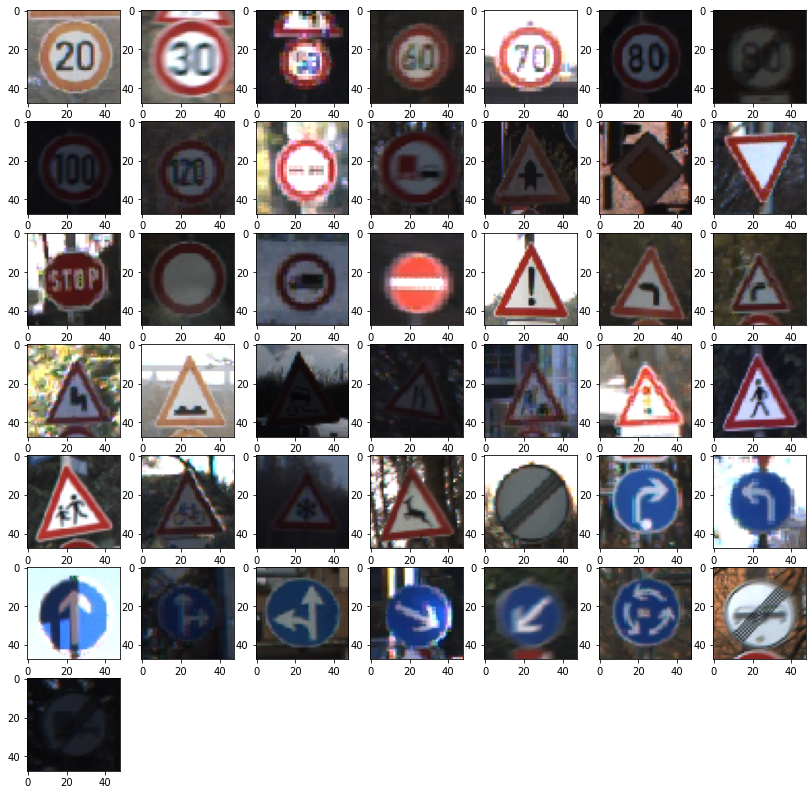

In [11]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

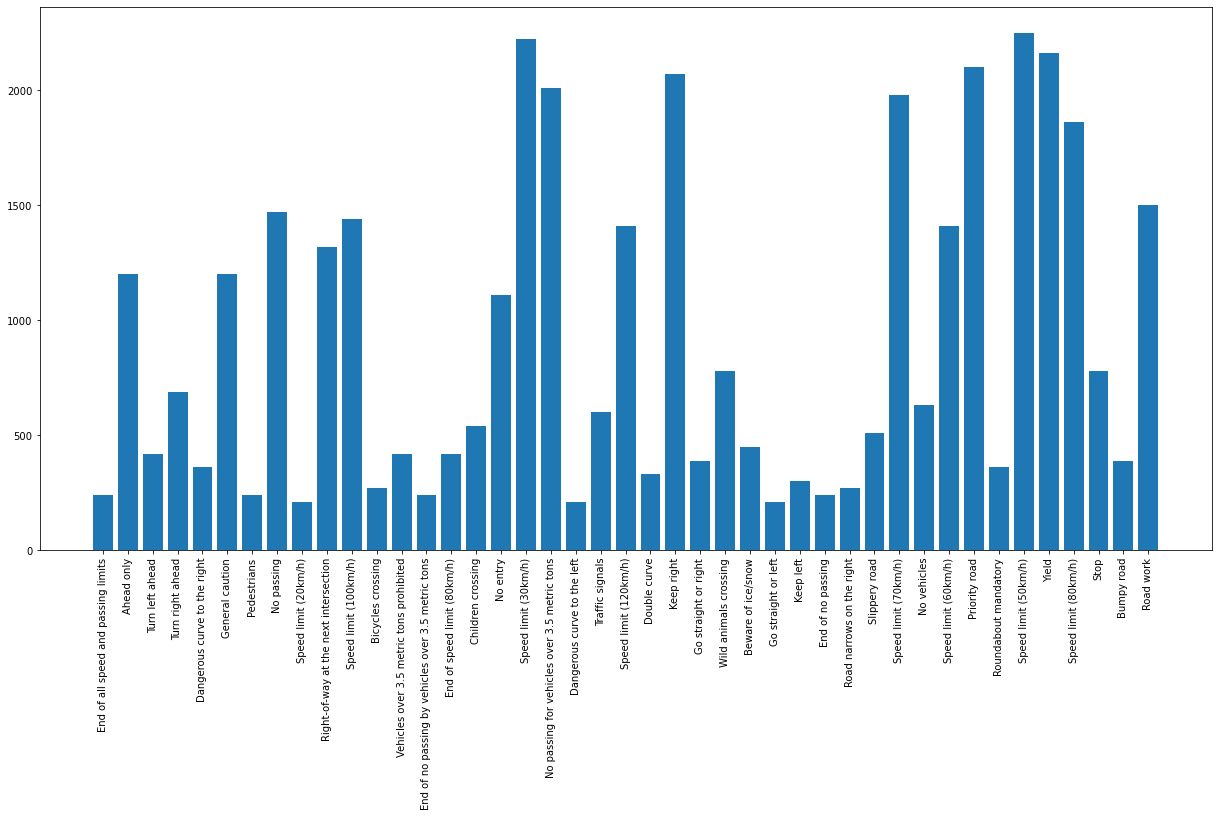

In [12]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])



plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Data Augmentation
### Keras ImageDataGenerator

NOTE:
- We opt not to use zoom as it will distort the sign shapes
- We also opt not to horizontal and vertical flips and signs have directional information which would be lost

Found 27447 images belonging to 43 classes.


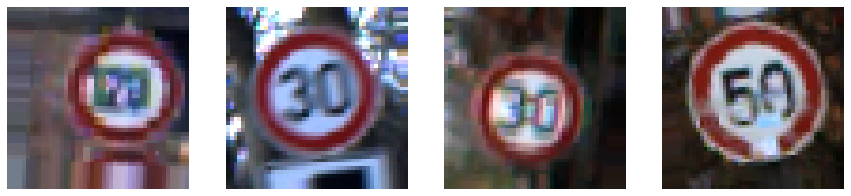

In [13]:
# dry running the generator and fine-tunning the parameters

train_datagen = ImageDataGenerator(validation_split=0.3, 
    # we will not use vertical/horizontal flip as signs have directional information that is revelant
    # adding a img rotation of up to 20º
    rotation_range=10,
    # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
    width_shift_range=.1, 
    height_shift_range=.1,
    fill_mode='nearest',
    # adding a brightness range of 1 to 1.2 - after visual inspection
    brightness_range=[1,1.2]
    # zoom
    #zoom_range=0.2,
    #zca_whitening
    )
        
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    class_mode='categorical'
    )

# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')


### Random over sampling minority classes

In [14]:
train_X = []
train_y = []
ds = []
for i in range(0,cat_num):
    n = str(i)
    train_Path = train_dir + "/" + n
    label = [0 for i in range(0, cat_num)]
    label[i] = 1
    for filename in os.listdir(train_Path):
        img = load_img(train_Path + "/" + filename, target_size=(img_width, img_height))
        img = img_to_array(img)
        train_X.append(img)
        train_y.append(label)
        ds.append([train_Path, label, i])
train_X = np.asarray(train_X)
train_X = np.asarray(train_X, dtype = "float32")
train_y = np.asarray(train_y, dtype= "float32")
print(train_X.shape, train_y.shape)

(39209, 48, 48, 3) (39209, 43)


In [15]:
ds = pd.DataFrame(ds, columns=["path", "one_hot", "label"])

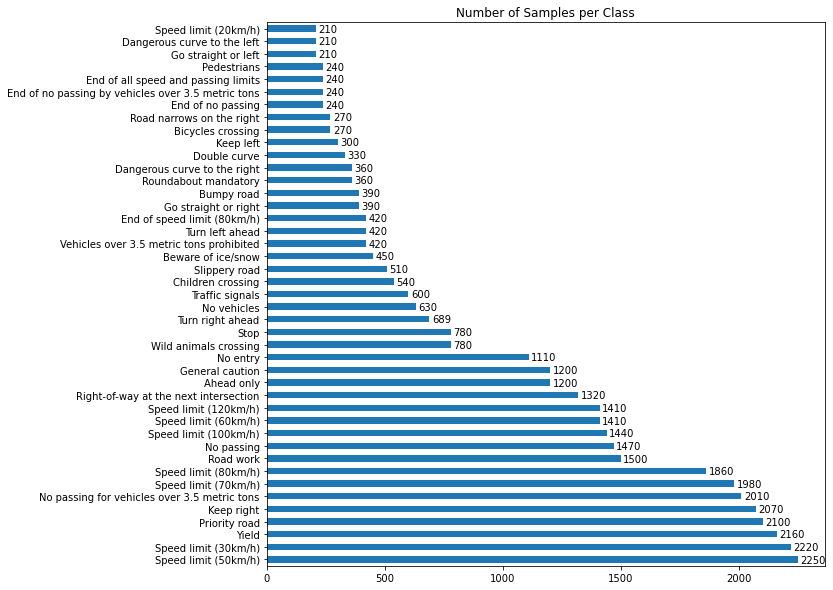

In [16]:
ax = ds['label'].value_counts().plot(kind='barh', figsize = (10,10), title='Number of Samples per Class')
ax.set_yticklabels(list(map(lambda x: classes[x], ds['label'].value_counts().index.tolist())))            
for i, v in enumerate(ds['label'].value_counts()):
   ax.text(v + 10, i - 0.25, str(v), color='black')

In [18]:
# Enxtending the Image data generator to balance the dataset

from keras.utils.data_utils import Sequence as KerasSequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(KerasSequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=batch_size):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(random_state=0), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [19]:
# training & dataset Dry-Run
# With Keras data augmentation
# We will not use flow from directory as it will not allow us to balance the dataset with RandomOverSampling

#training dataset image generator with data augmentation
train_datagen_dummy = ImageDataGenerator(
    # we will not use vertical/horizontal flip as signs have directional information that is revelant
    # adding a img rotation of up to 20º
    rotation_range=10,
    # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
    width_shift_range=.1, 
    height_shift_range=.1,
    fill_mode='nearest',
    # adding a brightness range of 1 to 1.2 - after visual inspection
    brightness_range=[1,1.2],
    # zoom
    #zoom_range=0.2
    )

train_balanced_gen_dummy = BalancedDataGenerator(train_X, train_y, train_datagen_dummy, batch_size=batch_size)

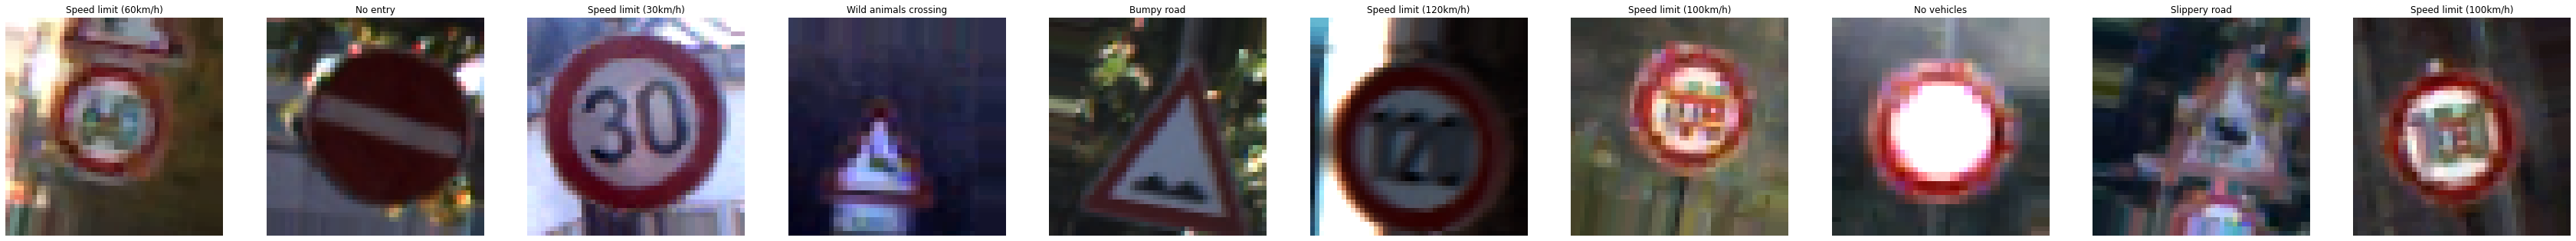

In [20]:
# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(60,60))
for i in range(10):

  # convert to unsigned integers for plotting
  image = train_balanced_gen_dummy.__getitem__(0)

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  cat = image[1][i].astype('uint8')
  cat = int(np.where(cat == 1)[0])
  label = classes[cat]
  image = np.squeeze(image[0][i].astype('uint8'))

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].title.set_text(label)
  ax[i].axis('off')

In [21]:
# training & dataset
# With Keras data augmentation
# We will not use flow from directory as it will not allow us to balance the dataset with RandomOverSampling

def get_balanced_train_val_data (X, y, batch_size):
    # Applying a validation split

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=1 )
    #training dataset image generator with data augmentation
    train_datagen = ImageDataGenerator(
        # we will not use vertical/horizontal flip as signs have directional information that is revelant
        # adding a img rotation of up to 20º
        rotation_range=10,
        # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
        width_shift_range=.1, 
        height_shift_range=.1,
        fill_mode='nearest',
        # adding a brightness range of 1 to 1.2 - after visual inspection
        brightness_range=[1,1.2],
        # zoom
        #zoom_range=0.2,
        rescale=1./255)

    train_balanced_gen = BalancedDataGenerator(X_train, y_train, train_datagen, batch_size=batch_size)

    val_balanced_gen = BalancedDataGenerator(X_val, y_val, train_datagen, batch_size=batch_size)

    return train_balanced_gen, val_balanced_gen

In [22]:
train_balanced_gen, val_balanced_gen = get_balanced_train_val_data(train_X, train_y, batch_size=batch_size)

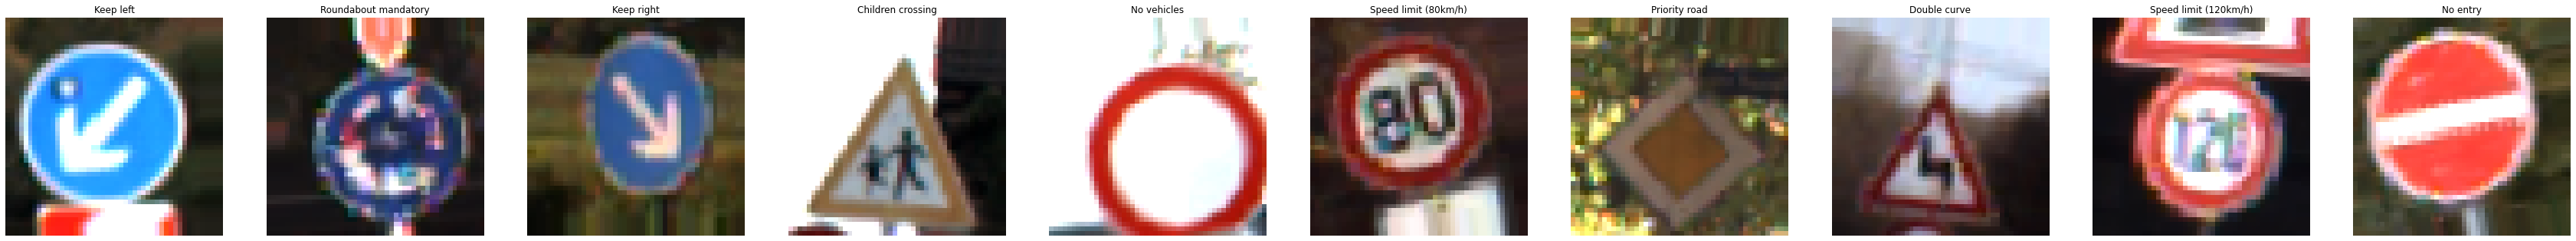

In [23]:
# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(60,60))
for i in range(10):

  # convert to unsigned integers for plotting
  image = train_balanced_gen.__getitem__(0)

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  cat = image[1][i].astype('uint8')
  cat = int(np.where(cat == 1)[0])
  label = classes[cat]
  image = np.squeeze((image[0][i] * 255).astype('uint8'))

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].title.set_text(label)
  ax[i].axis('off')

In [107]:
def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(
        rescale=1./255
        )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False,
        sorted=False,
        classes=class_indexes
        )
    
    return test_generator

In [108]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


In [70]:
print('Batches train=%d, val=%d, test=%d :: Steps per epoch=%d' % (len(train_balanced_gen), len(val_balanced_gen), len(test_generator), train_balanced_gen.steps_per_epoch))


Batches train=267, val=111, test=50 :: Steps per epoch=267


In [27]:
# looking at the training dataset distribution
y_gen = [train_balanced_gen.__getitem__(0)[1] for i in range(train_balanced_gen.steps_per_epoch)]



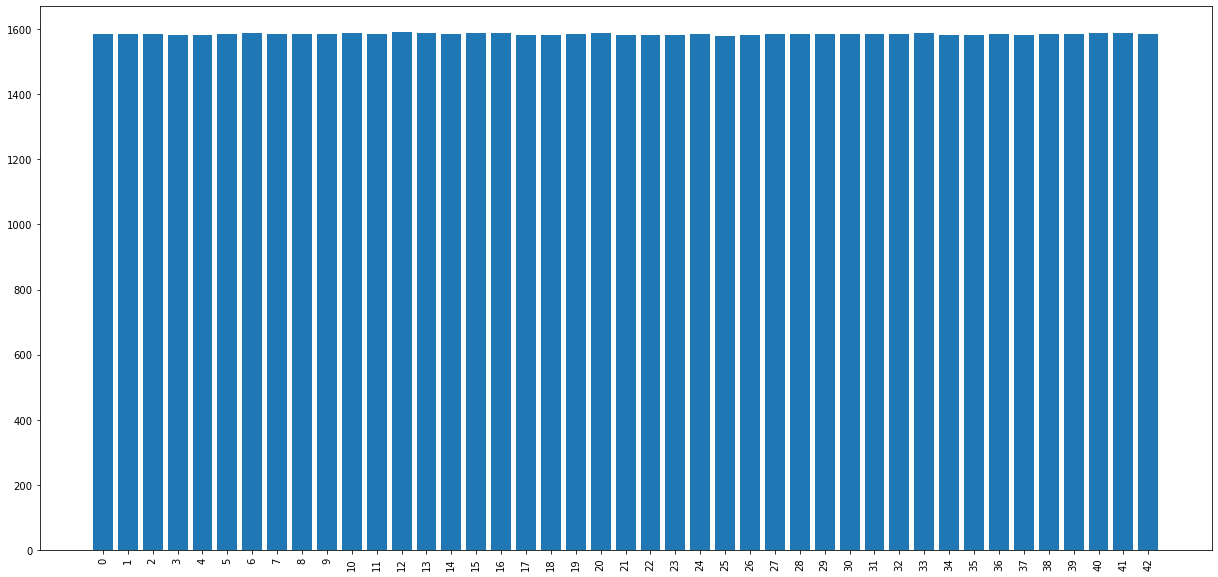

In [28]:
t = []
for batch in y_gen:
    [t.append(int(np.where(cat == 1)[0])) for cat in batch]
labels, counts = np.unique(t, return_counts=True)

plt.figure(figsize=(21,10))  
plt.bar(labels, counts)
plt.xticks(labels, rotation='vertical')
plt.show()

In [29]:
# looking at the validation dataset distribution
y_gen_val = [val_balanced_gen.__getitem__(0)[1] for i in range(val_balanced_gen.steps_per_epoch)]

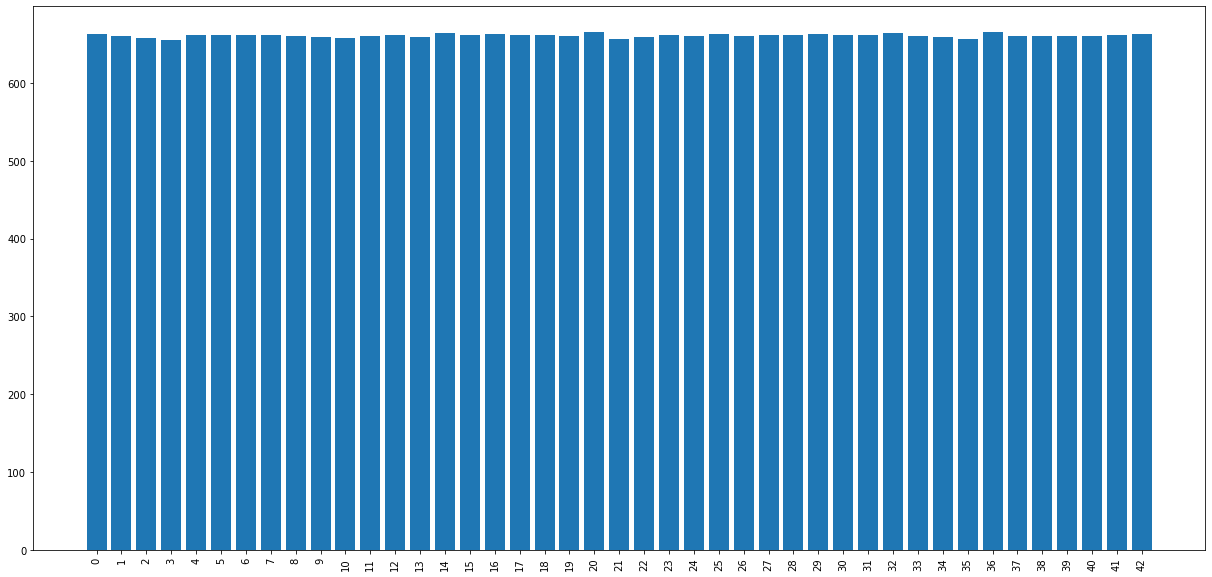

In [30]:
v = []
for batch in y_gen_val:
    [v.append(int(np.where(cat == 1)[0])) for cat in batch]
labels, counts = np.unique(v, return_counts=True)

plt.figure(figsize=(21,10))  
plt.bar(labels, counts)
plt.xticks(labels, rotation='vertical')
plt.show()

In [31]:
# getting some test images for XAI
X, y = next(test_generator)
to_explain = X[20:30]


In [32]:
# The differences be
# Calculating the weights to compensate for the class imbalance
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight(
#        class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
# class_weights

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [33]:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True,
    "steps_per_epoch": train_balanced_gen.steps_per_epoch,
    "lr": 0.001,
    "validation_split": 0.3
}

## Baseline

- No Class weights

### Training And Evaluating The Model

## miniVGGNet


In [34]:
chanDim = -1
miniVGGmodel = Sequential()
# MLP - input layer
miniVGGmodel.add(Conv2D(8, (5, 5), activation = relu, padding="same", input_shape=(img_width, img_height, 3)))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(MaxPooling2D(pool_size=(2, 2)))

miniVGGmodel.add(Conv2D(16, (3, 3), activation = relu, padding="same"))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(Conv2D(16, (3, 3), activation = relu, padding="same"))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(MaxPooling2D(pool_size=(2, 2)))

# first set of FC => RELU layers
miniVGGmodel.add(Flatten())
miniVGGmodel.add(Dense(units=128, activation=relu))
miniVGGmodel.add(BatchNormalization())
miniVGGmodel.add(Dropout(0.5))

miniVGGmodel.add(Flatten())
miniVGGmodel.add(Dense(units=128, activation=relu))
miniVGGmodel.add(BatchNormalization())
miniVGGmodel.add(Dropout(0.5))

miniVGGmodel.add(Dense(units=cat_num, activation=softmax))

# Check built model:
miniVGGmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                                        

2022-02-07 10:10:19.825845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=mlops_config["lr"])

miniVGGmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [36]:
# Common attributes:
# mlops

mlops_config['epochs'] = 100
mlops_config['loss'] = 'categorical_crossentropy'
#mlops_config['validation_steps'] = 50
mlops_config['optimizer'] = 'adam'
mlops_config['restore_best_weights'] = True
mlops_config['metrics'] = ['acc', f1]

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=mlops_config['restore_best_weights'])

In [38]:
# MLOps init and callback
run_id = 'TS_miniVGG' + str(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
run = wandb.init(name=run_id , project='CNN_TS_group16', config=mlops_config)

start = timeit.default_timer()

history_miniVGGmodel = miniVGGmodel.fit(
    train_balanced_gen,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_balanced_gen,
    #validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    #class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
run.log({'time-elapsed': stop - start})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


No supported GPU was found.


Epoch 1/100
267/267 [==============================] - 122s 453ms/step - loss: 2.5625 - acc: 0.3039 - f1_score: 0.2967 - val_loss: 2.7431 - val_acc: 0.2759 - val_f1_score: 0.2551
Epoch 2/100
267/267 [==============================] - 122s 456ms/step - loss: 1.1784 - acc: 0.6278 - f1_score: 0.6248 - val_loss: 0.7165 - val_acc: 0.7896 - val_f1_score: 0.7856
Epoch 3/100
267/267 [==============================] - 124s 466ms/step - loss: 0.7591 - acc: 0.7604 - f1_score: 0.7591 - val_loss: 0.4056 - val_acc: 0.8764 - val_f1_score: 0.8758
Epoch 4/100
267/267 [==============================] - 145s 542ms/step - loss: 0.5573 - acc: 0.8236 - f1_score: 0.8230 - val_loss: 0.3249 - val_acc: 0.9002 - val_f1_score: 0.8997
Epoch 5/100
267/267 [==============================] - 137s 515ms/step - loss: 0.4403 - acc: 0.8619 - f1_score: 0.8616 - val_loss: 0.2132 - val_acc: 0.9378 - val_f1_score: 0.9378
Epoch 6/100
267/267 [==============================] - 130s 488ms/step - loss: 0.3559 - acc: 0.8885 - f1_

color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


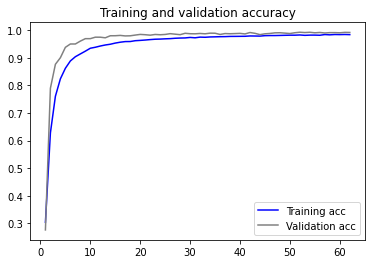

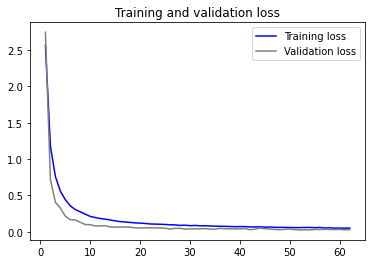

In [39]:
plot_results(history_miniVGGmodel)

In [105]:
test_generator.reset()
pred=miniVGGmodel.predict(test_generator, verbose=1)

50/50 [==============================] - 27s 551ms/step


In [92]:
predicted_class_indices=np.argmax(pred,axis=1)
pred_labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in classes.items())
predictions = [labels[k] for k in predicted_class_indices]

In [106]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '5': 38,
 '6': 39,
 '7': 40,
 '8': 41,
 '9': 42}

In [93]:
np.array(predictions).shape

(12630,)

Confusion matrix, without normalization
[[ 45   0   1 ...   0   0   0]
 [  1 693  14 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 [  0   0   3 ...   0   0   0]]


<module 'matplotlib.pyplot' from '/usr/local/Caskroom/miniforge/base/envs/tf-macos/lib/python3.8/site-packages/matplotlib/pyplot.py'>

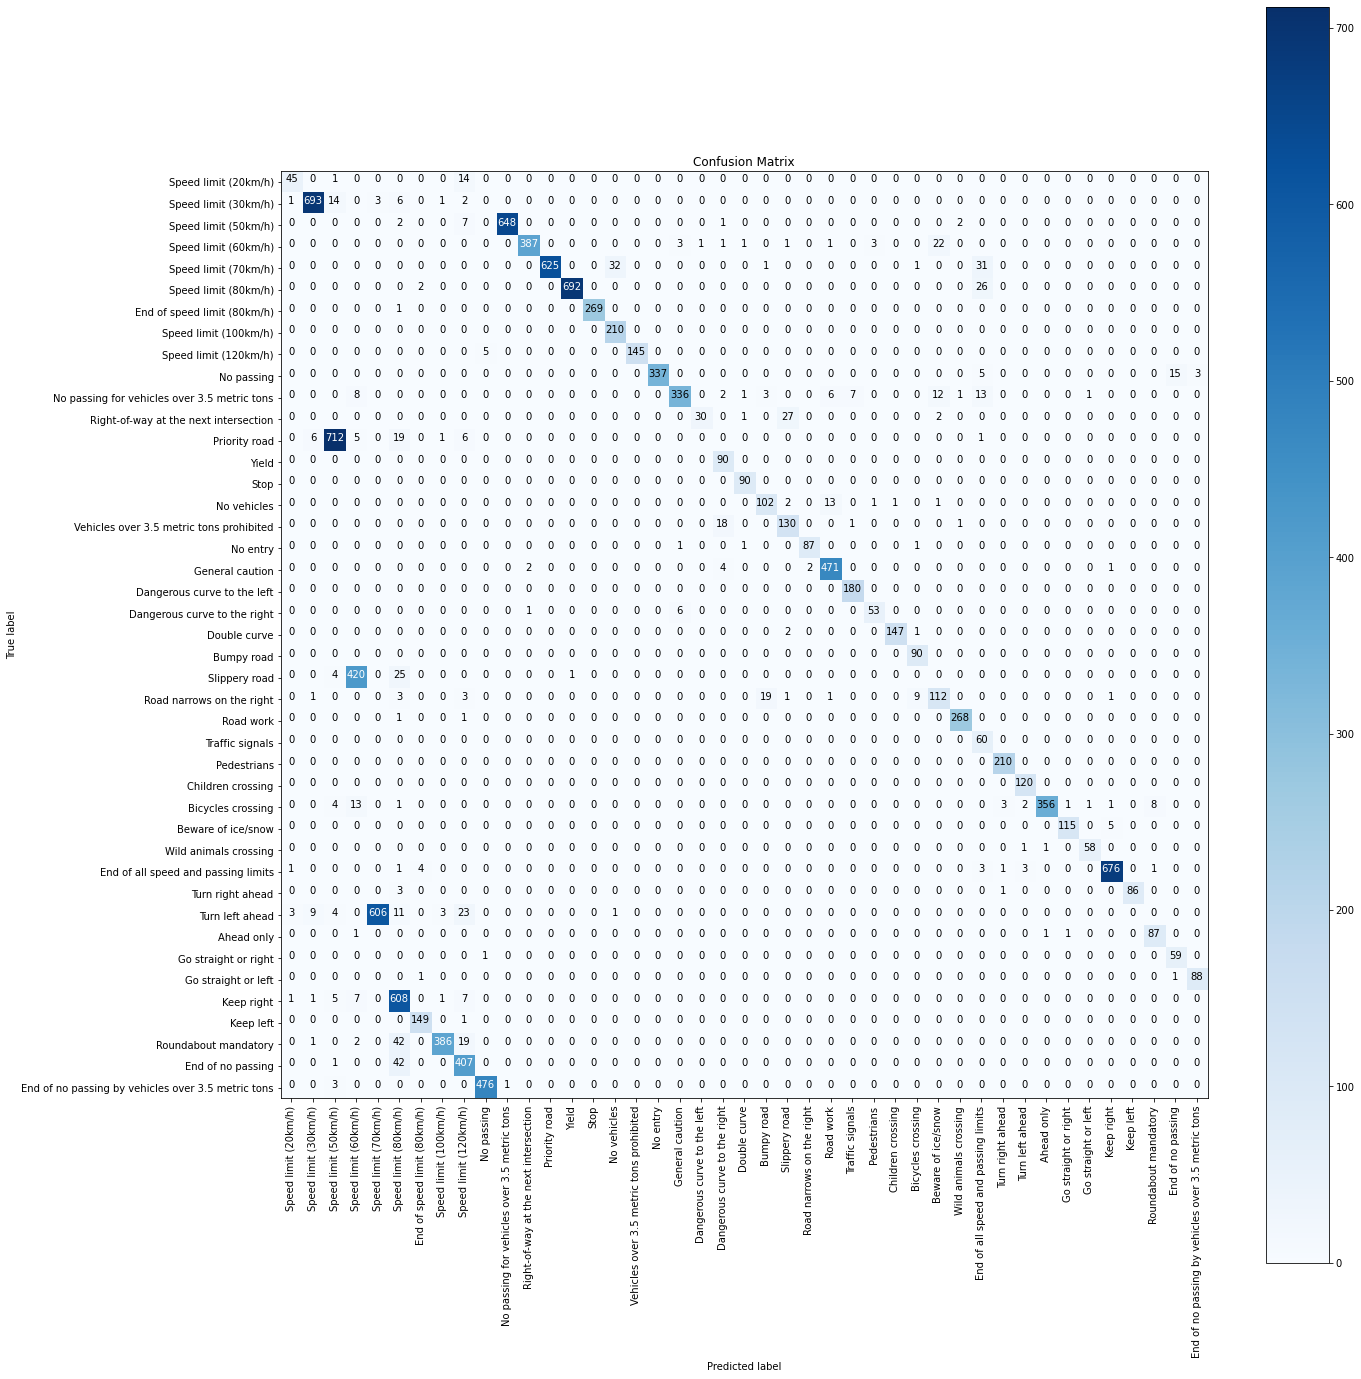

In [95]:
# Confusion Matrix
cm = confusion_matrix(test_generator.classes, predictions)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
miniVGGmodel.save('miniVGGmodel_final.h5')

50/50 [==============================] - 29s 594ms/step
Confusion matrix, without normalization
[[ 45   0   1 ...   0   0   0]
 [  1 693  14 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 [  0   0   3 ...   0   0   0]]


<module 'matplotlib.pyplot' from '/usr/local/Caskroom/miniforge/base/envs/tf-macos/lib/python3.8/site-packages/matplotlib/pyplot.py'>

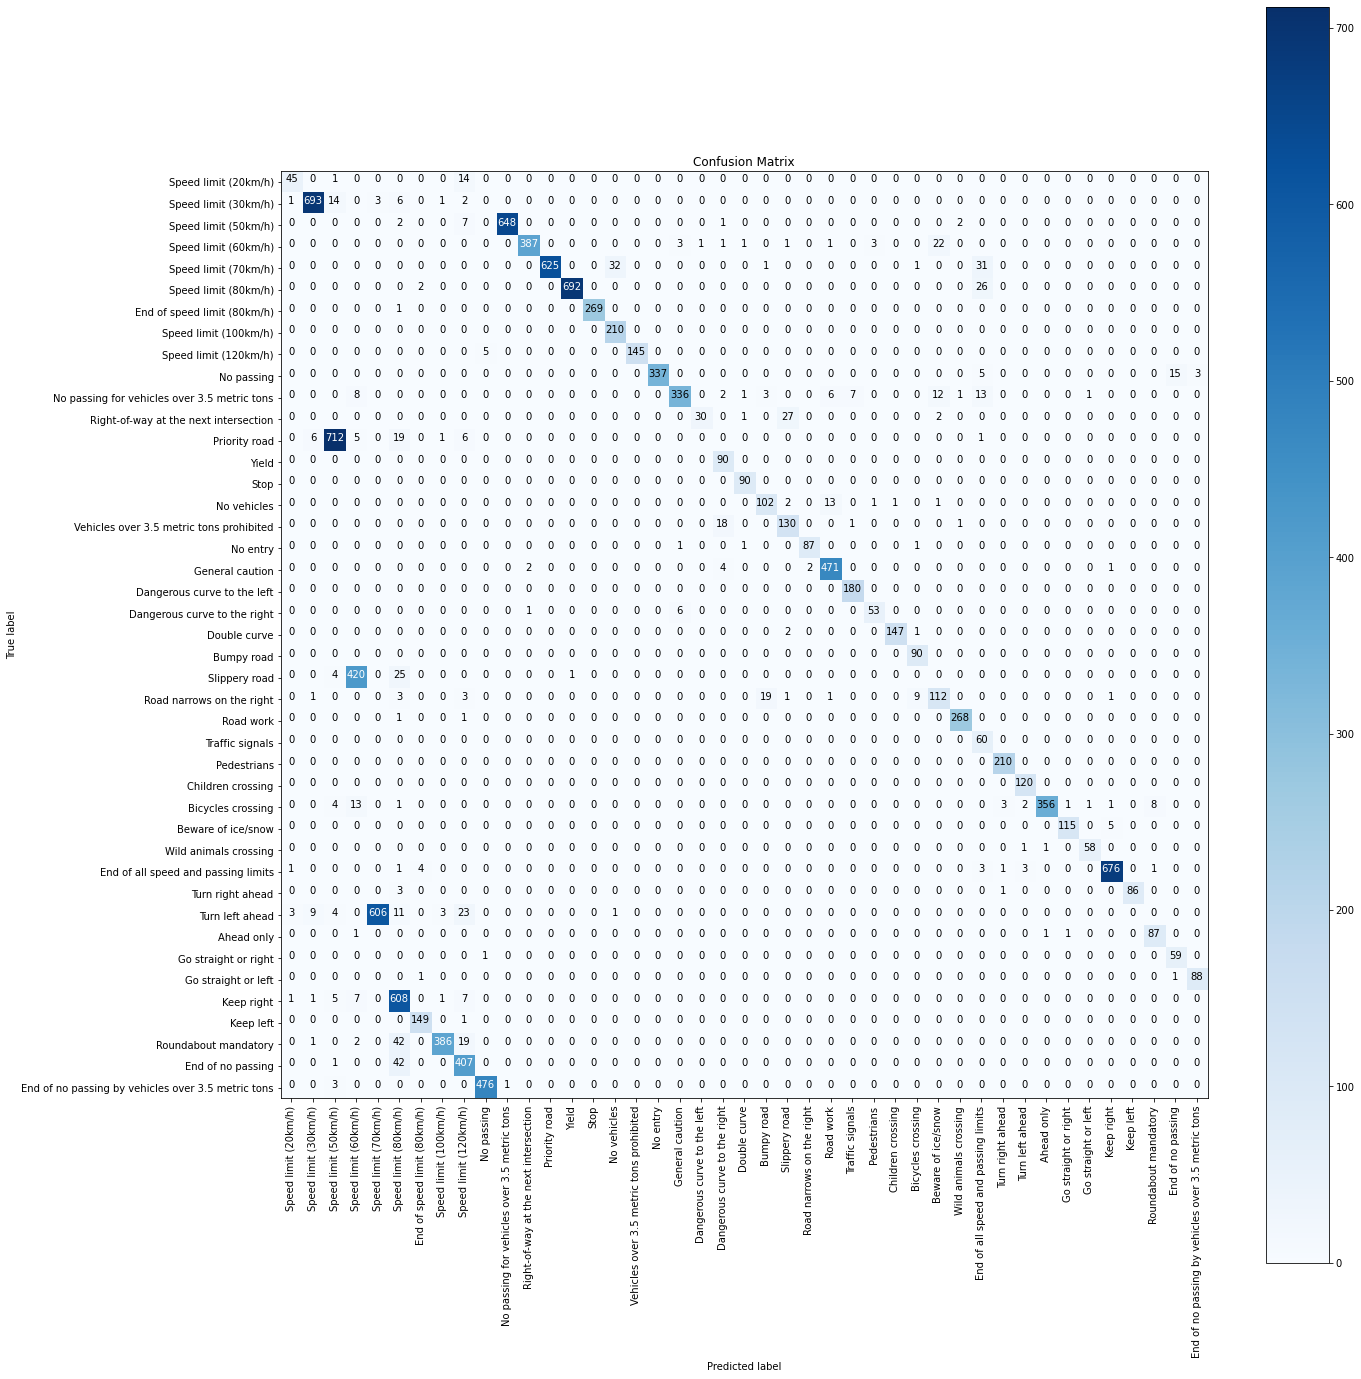

In [104]:
# predictions on Test data
test_generator.reset()

Y_pred = miniVGGmodel.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=-1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
Y_pred = miniVGGmodel.predict(test_generator, steps=len(test_generator))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.86      0.92        70
                              Speed limit (30km/h)       0.97      0.98      0.98       715
                              Speed limit (50km/h)       0.00      0.00      0.00       739
                              Speed limit (60km/h)       0.00      0.00      0.00       449
                              Speed limit (70km/h)       0.00      0.00      0.00       660
                              Speed limit (80km/h)       0.00      0.00      0.00       648
                       End of speed limit (80km/h)       0.00      0.00      0.00       149
                             Speed limit (100km/h)       0.00      0.00      0.00       481
                             Speed limit (120km/h)       0.00      0.00      0.00       428
                                        No passing       0.00      0.00      0.

In [ ]:
#uploading artifacts to MLOps
fig.savefig('./confusion_matrix.png')
report = metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values()), output_dict=True)
report = pd.DataFrame(report).T
df_report = wandb.Table(data=report)

artifact = wandb.Artifact(run_id, type='Confusion Matrix', description='Test Results')
artifact.add_file('confusion_matrix.png')
artifact.add(df_report, name='Test F1 Scores')
run.log_artifact(artifact)

Shape before entering the conv layer: (1, 48, 48, 3)


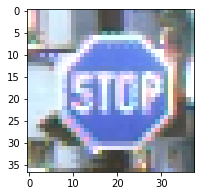

In [ ]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

2022-02-07 08:50:24.806688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
divide by zero encountered in true_divide


(1, 48, 48, 8)
(1, 24, 24, 8)
(1, 24, 24, 16)
(1, 24, 24, 16)
(1, 24, 24, 16)
(1, 24, 24, 16)
(1, 12, 12, 16)
(1, 2304)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 43)


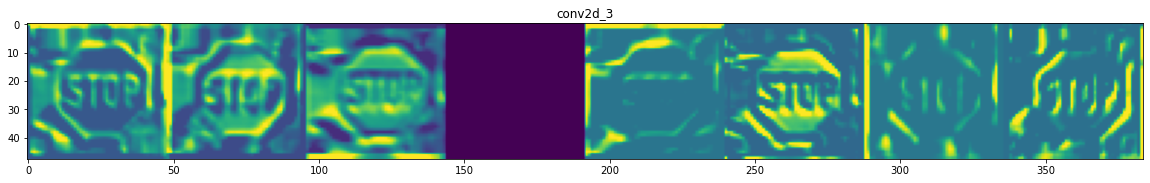

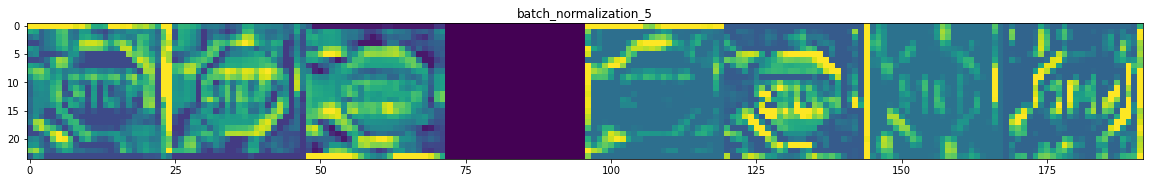

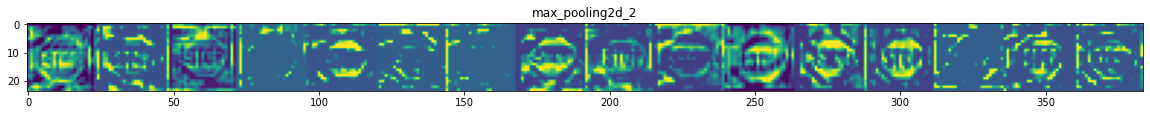

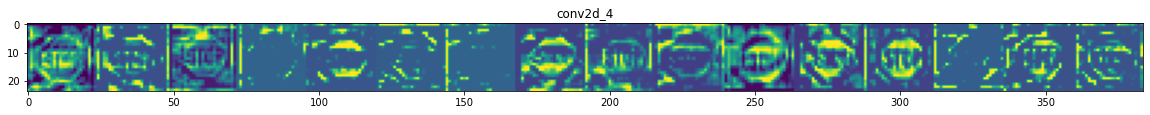

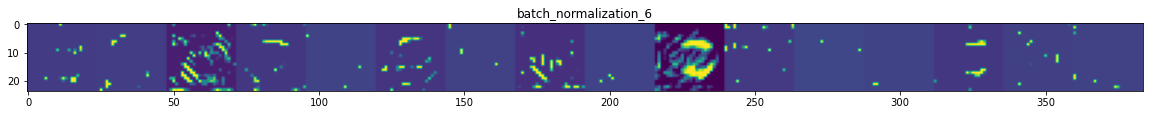

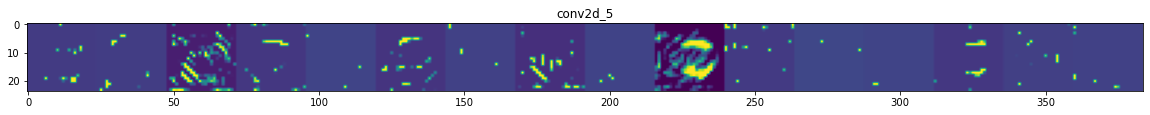

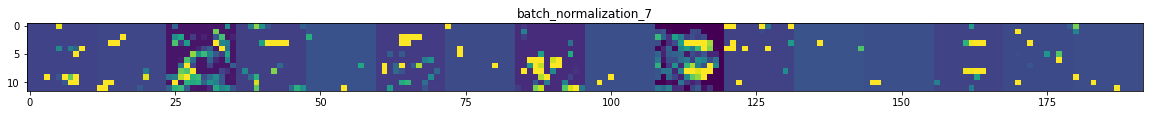

In [ ]:
plot_feature_maps(miniVGGmodel, img)

8


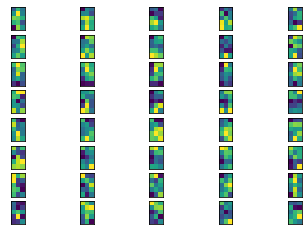

16


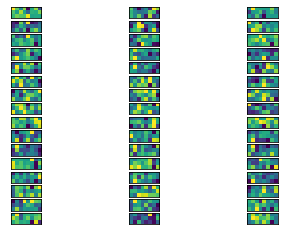

16


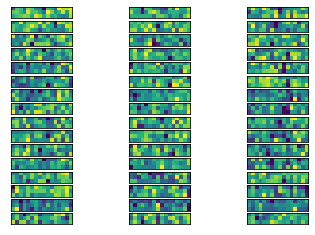

In [ ]:
show_filters(miniVGGmodel)

In [ ]:
explainer = shap.GradientExplainer(miniVGGmodel, X)
# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values(to_explain)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2022-02-07 08:50:40.276164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-07 08:50:40.960818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-07 08:50:41.614753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-07 08:50:42.270527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-07 08:50:42.930061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-07 08:

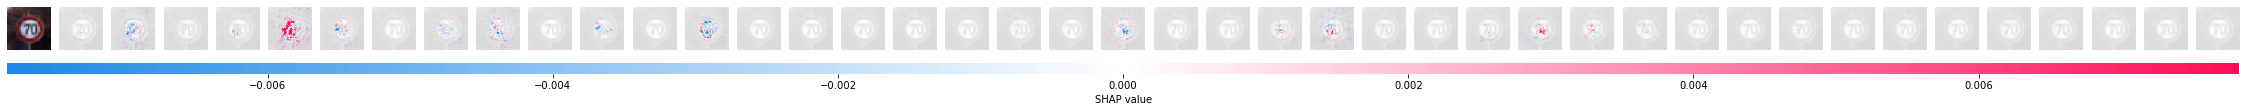

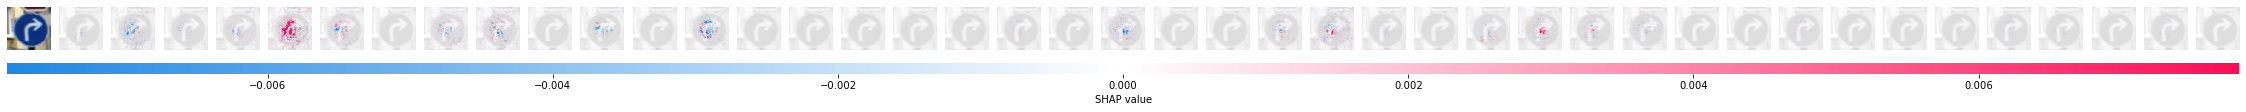

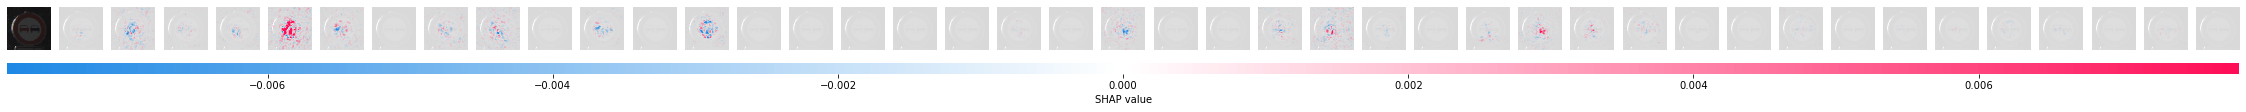

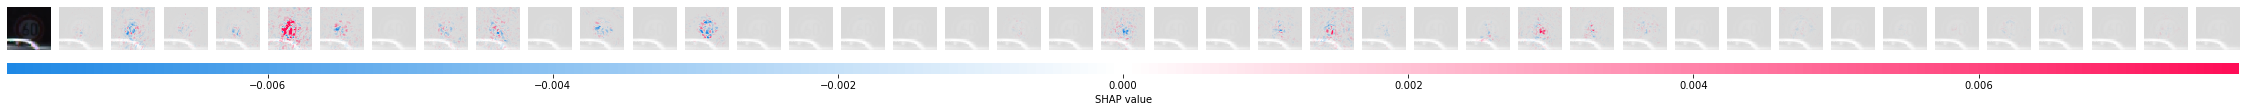

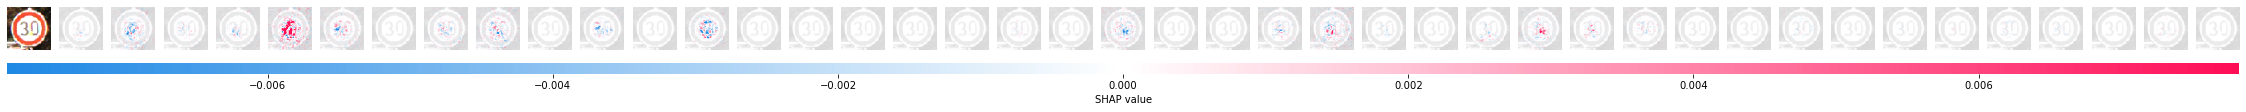

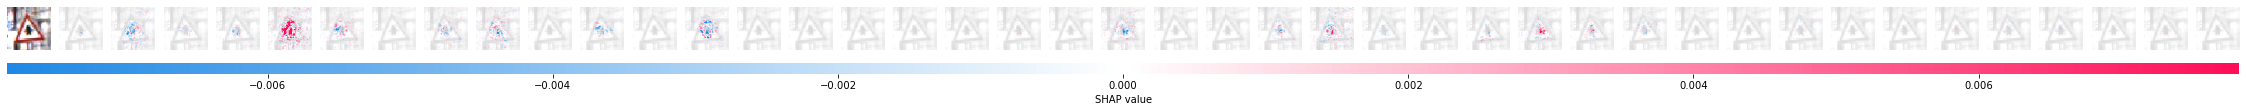

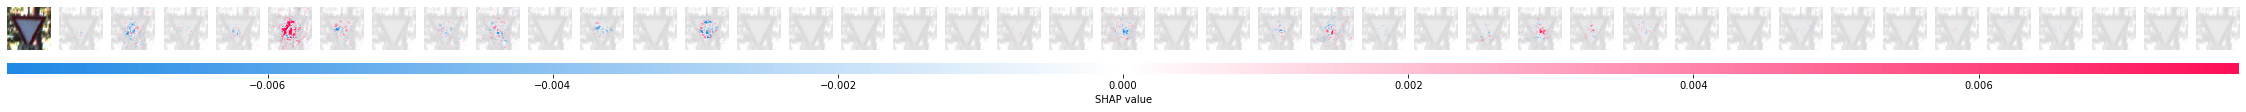

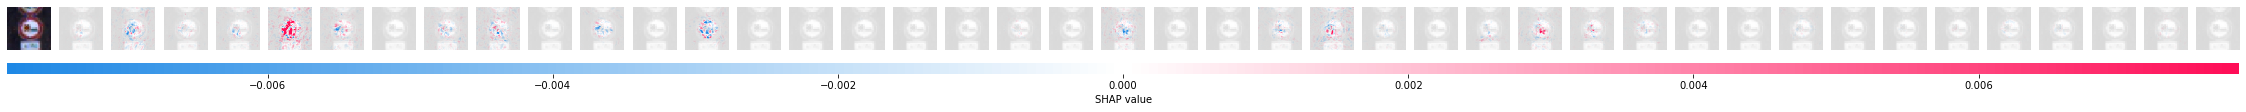

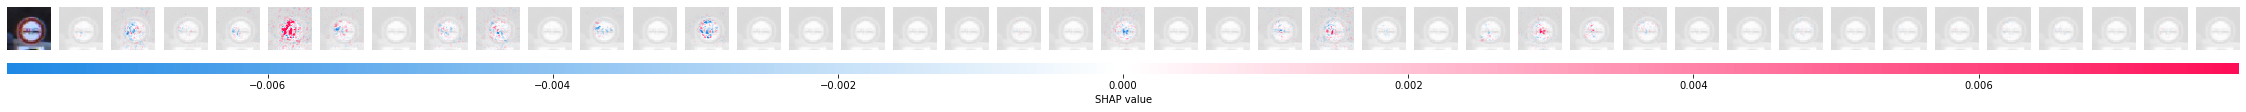

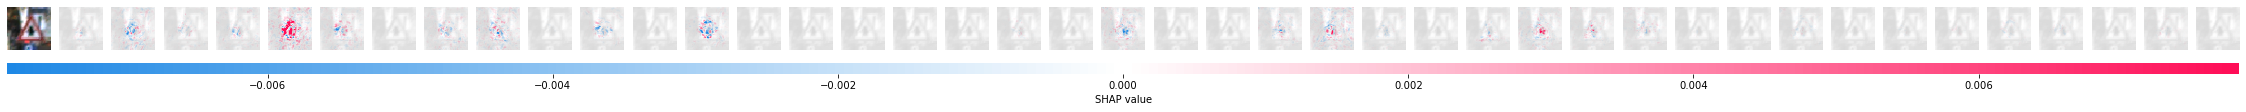

[None, None, None, None, None, None, None, None, None, None]

In [ ]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
[shap.image_plot([shap_values[i][0] for i in range(42)], img, width=40) for img in to_explain]

In [ ]:
run.finish()

acc,▁▅▆▇▇▇██████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▅▆▇▇▇██████████████████████████████████
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▆▇█████████████████████████████████████
val_f1_score,▁▆▇█████████████████████████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.98528
best_epoch,44
best_val_loss,0.02627


In [ ]:
wandb.finish()

# 